In [1]:
# Import libraries
import numpy as np 
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Prepare Dataset
# load data

# relative path to npz files
path = 'Measurements/manual single top deformed at 20Hz'
file_name = 'output_batch_%d.npz'

def load_file(path, batch_id):
    """
    Loads in the memory a specific batch located in the given path.

    Returns a numpy NpzFile object with the image frames np array named
    as "frames" and the force measurements named as "frames".
    """
    combined_path = os.path.join(path,file_name %i)
    data = np.load(combined_path)
    return data

In [3]:
# Create RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_channels, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(input_channels, 9, kernel_size = 5, stride = 1, padding = 2)
        self.pool = nn.MaxPool2d(kernel_size = 4, stride = 4)
        self.conv2 = nn.Conv2d(9, 18, kernel_size = 5, stride = 1, padding = 2)
        
        # RNN
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(18 * 16 * 30, hidden_dim, layer_dim, batch_first=True, dropout = 0.2, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Convolutional layers
        x = self.pool(nn.ELU()(self.conv1(x)))
        x = self.pool(nn.ELU()(self.conv2(x)))
        
        # Reshape for RNN
        # x = torch.reshape(x, (100, 10, 18 * 16 * 30))
        x = torch.reshape(x, (10, 10, 18 * 16 * 30))  # Reshape to (batch_size, seq_len, input_size)
        #print("Size of x:", x.size())  # Print size of x
        
        # RNN
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        #print("Size of h0:", h0.size())  # Print size of h0 - Debugging - Obsolete
        out, hn = self.rnn(x, h0)
        
        # Output layer
        out = self.fc(out) 
        # out = torch.reshape(out, (1000, 1))
        out = torch.reshape(out, (100, 1)) # go back to compare to labels
        return out

In [4]:
# Create RNN
input_channels = 3  # RGB channels
hidden_dim = 200  # hidden layer dimension
layer_dim = 2     # number of hidden layers
output_dim = 1   # output dimension

model = RNNModel(input_channels, hidden_dim, layer_dim, output_dim)

# Define your loss function
error = nn.MSELoss()

# Define your optimizer
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [5]:
# Training

file_size = 1000 # one file contains 1000 samples
num_epochs = 20
files_num = 2 # how many files to load
seq_dim = 10
loss_list = []
iteration_list = []
accuracy_list = []
count = 0
batch_size = 100 # should be something that leaves zero reminder when it divides the file_size
last_iter = -files_num * file_size/batch_size
for epoch in range(num_epochs):
    for i in range(files_num):
        data = load_file(path, i)
        
        for i in range(int(file_size/batch_size)):
            images = torch.from_numpy(data['frames'][i*batch_size:(i+1)*batch_size,:,:,:]).float()
            labels = torch.from_numpy(data['forces'][i*batch_size:(i+1)*batch_size,2]).float()        
            # print(images.shape)  # Add this line to check the shape of images - Debugging purposes
            images = images.permute(0, 3, 1, 2)
                
            # Clear gradients
            optimizer.zero_grad()
            
            # Forward propagation
            outputs = model(images)
            outputs = torch.squeeze(outputs)
            
            # Calculate loss
            loss = error(outputs, labels)
            
            # Backpropagation
            loss.backward()
            
            # Update parameters
            optimizer.step()
            
            count += 1
                
            # Store loss and iteration
            loss_list.append(loss.data) #* (forces_z_std^2)
    # Print Loss
    print('Epoch: {}, MSE Loss: {}'.format((epoch+1), np.mean(loss_list[int(last_iter):]))) # * (forces_z_std^2)

Epoch: 1, MSE Loss: 67.03858184814453
Epoch: 2, MSE Loss: 8.154960632324219
Epoch: 3, MSE Loss: 2.8784918785095215
Epoch: 4, MSE Loss: 1.9918529987335205
Epoch: 5, MSE Loss: 1.492382526397705
Epoch: 6, MSE Loss: 1.1219197511672974
Epoch: 7, MSE Loss: 0.87245112657547
Epoch: 8, MSE Loss: 0.7660211324691772
Epoch: 9, MSE Loss: 0.6192594766616821
Epoch: 10, MSE Loss: 0.5615960359573364
Epoch: 11, MSE Loss: 0.5365857481956482
Epoch: 12, MSE Loss: 0.4887928068637848
Epoch: 13, MSE Loss: 0.45033973455429077
Epoch: 14, MSE Loss: 0.44845128059387207
Epoch: 15, MSE Loss: 0.41500526666641235
Epoch: 16, MSE Loss: 0.3743651211261749
Epoch: 17, MSE Loss: 0.36381444334983826
Epoch: 18, MSE Loss: 0.3501524329185486
Epoch: 19, MSE Loss: 0.3577442467212677
Epoch: 20, MSE Loss: 0.3433437943458557


[tensor(209.6279), tensor(255.2083), tensor(121.0022), tensor(67.7901), tensor(72.7014), tensor(95.6776), tensor(79.2049), tensor(55.9427), tensor(41.4206), tensor(44.2486), tensor(35.4829), tensor(51.9273), tensor(47.5969), tensor(31.1133), tensor(23.6617), tensor(22.9288), tensor(25.8019), tensor(19.1400), tensor(21.2715), tensor(19.0231), tensor(15.7309), tensor(13.6423), tensor(10.5604), tensor(10.5316), tensor(15.9692), tensor(10.4620), tensor(8.0624), tensor(9.2497), tensor(7.0840), tensor(6.3310), tensor(5.4603), tensor(6.7589), tensor(7.4036), tensor(5.1103), tensor(4.5497), tensor(6.1013), tensor(4.8221), tensor(4.9503), tensor(4.1045), tensor(6.2147), tensor(3.8175), tensor(2.5601), tensor(3.6823), tensor(4.1143), tensor(3.4850), tensor(2.6115), tensor(2.3620), tensor(3.4819), tensor(2.8160), tensor(2.8921), tensor(2.5300), tensor(3.0549), tensor(2.1113), tensor(2.5429), tensor(3.0344), tensor(3.0897), tensor(2.5729), tensor(1.9765), tensor(2.5262), tensor(2.3084), tensor(2.4

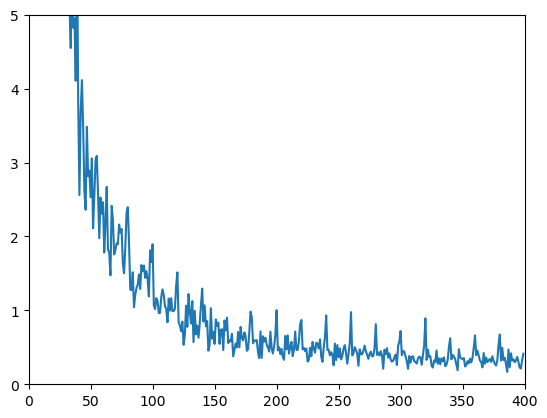

In [6]:
print(loss_list)
print(np.sqrt(np.mean(loss_list[-20:])))
plt.plot(range(len(loss_list)), loss_list)
plt.xlim((0,400))
plt.ylim((0,5))
plt.show()

In [7]:
print(outputs) # Small sanity check

tensor([-2.1637, -1.7495, -1.4801, -0.6333, -1.2201, -0.0983, -0.1355, -0.8148,
        -0.3435, -0.4004, -0.0728,  0.0563, -0.4854, -0.5130, -0.3931, -0.1449,
        -0.3364, -0.0821, -0.5105, -0.5808, -0.3740, -0.2816,  0.0471,  0.3000,
        -0.7772, -0.0944, -0.0744, -0.2332, -0.2072,  0.1673, -0.2452, -0.5228,
        -2.0017, -2.3652, -2.4606, -3.7290, -4.2695, -4.3258, -5.0241, -4.1871,
        -4.6685, -4.7725, -4.9985, -3.6028, -3.5902, -2.5288, -0.6030, -1.0862,
        -1.0695, -1.2297, -0.3970, -0.3145, -0.8253, -0.2758, -0.2521, -0.3168,
        -0.3040, -0.3965, -0.3947, -0.5458,  0.0874, -0.1007, -0.3506, -0.1249,
        -0.3092, -0.2456, -0.2814, -0.0598, -0.1910, -0.1388,  0.3232, -0.3033,
        -0.3293, -1.2624, -2.2740, -1.1916, -3.2507, -4.0872, -3.7607, -3.7671,
        -4.3118, -4.2782, -3.9567, -2.3358, -3.8690, -4.9020, -3.8977, -1.2612,
        -0.3900, -0.5494, -1.2061, -0.9844, -0.5924, -0.2004, -0.5663, -0.7882,
        -0.6571, -0.3619, -0.0848, -0.43

In [8]:
print(labels.float())

tensor([-0.9837, -0.1637, -0.1279, -0.1309, -0.1346, -0.1297, -0.1344, -0.1294,
        -0.1343, -0.1282, -0.1322, -0.1240, -0.1298, -0.1313, -0.1317, -0.1270,
        -0.1292, -0.1361, -0.1341, -0.1336, -0.1390, -0.1233, -0.1278, -0.1282,
        -0.1346, -0.1320, -0.1334, -0.1283, -0.1324, -0.3513, -1.0552, -1.5855,
        -2.5075, -2.8629, -3.2809, -3.5987, -4.0110, -4.4015, -4.5454, -4.9288,
        -5.1063, -5.1722, -4.9448, -4.5689, -3.3009, -1.5864, -0.2401, -0.1187,
        -0.1239, -0.1288, -0.1313, -0.1257, -0.1342, -0.1297, -0.1307, -0.1230,
        -0.1293, -0.1233, -0.1307, -0.1248, -0.1389, -0.1326, -0.1363, -0.1292,
        -0.1340, -0.1309, -0.1326, -0.1288, -0.1315, -0.1237, -0.1371, -0.3839,
        -0.8983, -1.3171, -2.2785, -2.7973, -3.4132, -3.8083, -4.2586, -4.6140,
        -4.6368, -4.7419, -4.7785, -4.7576, -4.3578, -3.5074, -1.8832, -0.4341,
        -0.1187, -0.1313, -0.1282, -0.1306, -0.1325, -0.1369, -0.1345, -0.1265,
        -0.1310, -0.1315, -0.1313, -0.12

Notes: Batch size of 100, sequence length of 10, dropout of 20%.
Next step: normalization.